In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn import preprocessing
color = sns.color_palette()
%matplotlib inline


In [38]:
df_train = pd.read_json('price_vs_median30.json')
df_test = pd.read_json('test.json')

In [1]:
from pandas import to_datetime
import numpy as np
import re


def basic_numeric_features(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df[
        "description"].apply(lambda x: len(x.split(" ")))
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    df["created_hour"] = df["created"].dt.hour
    return df


def num_keyword(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('elevator|cats|dogs|doorman|dishwasher|no fee|laundry|fitness', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i <= 5:
            nfeat_score.append(0)
        elif i == 6:
            nfeat_score.append(1)
        elif i == 7:
            nfeat_score.append(2)
        elif i == 8:
            nfeat_score.append(3)
        elif i == 9:
            nfeat_score.append(4)
        elif i == 10:
            nfeat_score.append(5)
        else:
            nfeat_score.append(6)

    df['n_num_keyfeat_score'] = nfeat_score
    return df


def no_photo(df):
    df['n_no_photo'] = [1 if i == 0 else 0 for i in map(len, df['photos'])]
    return df


def count_caps(df):
    def get_caps(message):
        caps = sum(1 for c in message if c.isupper())
        total_characters = sum(1 for c in message if c.isalpha())
        if total_characters > 0:
            caps = caps / (total_characters * 1.0)
        return caps
    df['amount_of_caps'] = df['description'].apply(get_caps)
    return df


def has_phone(df):
    # http://stackoverflow.com/questions/16699007/regular-expression-to-match-standard-10-digit-phone-number
    phone_regex = "(\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4})"
    has_phone = df['description'].str.extract(phone_regex)
    df['has_phone'] = [type(item) == unicode for item in has_phone]
    return df


def n_log_price(df):
    # n_price_sqrt improves original 'price' variable smoothing extreme
    # right skew and fat tails.
    # Use either 'price' or this new var to avoid multicolinearity.
    df['n_log_price'] = np.log(df['price'])
    return df


def n_expensive(df):
    # 'Low' interest make 70% population. Statistical analysis shows price
    # among 'Low' interest exhibits the highest kurtosis and skew.
    # n_expensive is 1 when the price is above 75% percentile aggregate
    # prices and 0 otherwise.
    # you can use it along with either price or n_price_sqrt.
    threshold_75p = df[['price']].describe().loc['75%', 'price']
    df['n_expensive'] = [
        1 if i > threshold_75p else 0 for i in list(df['price'])]
    return df


def dist_from_midtown(df):
    from geopy.distance import vincenty
    # pip install geopy
    # https://github.com/geopy/geopy
    # calculates vincenty dist
    # https://en.wikipedia.org/wiki/Vincenty's_formulae
    lat = df['latitude'].tolist()
    long_ = df['longitude'].tolist()
    midtown_lat = 40.7586
    midtown_long = -73.9838
    distance = []
    for i in range(len(lat)):
        distance.append(
            vincenty((lat[i], long_[i]), (midtown_lat, midtown_long)).meters)
    df['distance_from_midtown'] = distance
    return df


def price_vs_mean_30(df):
    # userfriendly for def_nearest_neighbour created earlier.
    # Output: df with price_vs_median for each row
    # The code below solves NA issues and round some results to save execution errors
    temp = pd.read_json("price_vs_median30.json")['price_vs_median_30']
    mean = np.mean(temp) 
    import math
    df['price_vs_median_30'] = [mean if math.isnan(i)== True  else round(i,2) for i in temp]

    return df

allow_pet(df_train)
laundry(df_train)
preWar(df_train)
furnished(df_train)
dishwash(df_train)
hardwood(df_train)
fitness(df_train)
doorman(df_train)
no_fee(df_train)

In [10]:
df_train.created = pd.to_datetime(df_train.created)

In [13]:
df_train['date_created'] = df_train.created.dt.date
df_train['weekday_created'] = df_train.created.dt.dayofweek
df_train['hour_created'] = df_train.created.dt.hour
df_train["created_day"] = df_train["created"].dt.day

df_train["num_photos"] = df_train["photos"].apply(len)
df_train["num_features"] = df_train["features"].apply(len)
df_train["num_description_words"] = df_train["description"].apply(lambda x: len(x.split(" ")))

df_train['interest_level'] = pd.Categorical(df_train['interest_level'], categories= ['low', 'medium', 'high'], ordered=True)

lbl = preprocessing.LabelEncoder()
lbl.fit(list(df_train['manager_id'].values))
df_train['manager_id'] = lbl.transform(list(df_train['manager_id'].values))
#list of id's to encode
manager_ids = list(df_train['manager_id'].values)
#new var to create
new_var = 'manager_id'#'manager_id_encoded'
#response var
resp_var = 'interest_level'


temp = pd.concat([df_train[new_var], pd.get_dummies(df_train[resp_var])], axis = 1).groupby(new_var).mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = df_train.groupby(new_var).count().iloc[:,1]

# compute skill
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']
unranked_managers_ixes = temp['count']<20
ranked_managers_ixes = ~unranked_managers_ixes
mean_values = temp.loc[ranked_managers_ixes, ['high_frac','low_frac', 'medium_frac','manager_skill']].mean()
temp.loc[unranked_managers_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

df_train['Price_P_Room'] = df_train['price']/df_train['bedrooms']
df_train['BB_ratio'] = df_train['bedrooms']/df_train['bathrooms']
df_train['is_studio'] = np.where(df_train['bedrooms'] == 0, '1', '0')
df_train['bathroom_listed'] = np.where(df_train['bathrooms'] == 0, '0', '1')
df_train['n_log_price'] = np.log(df_train['price'])
df_train.bedrooms[df_train.bedrooms == 0] = 1
df_train.bathrooms[df_train.bathrooms ==0] = 1

num_keyword(df_train)
no_photo(df_train)
count_caps(df_train)
n_expensive(df_train)
dist_from_midtown(df_train)


queensCenter = ((40.800760+40.542920)/2,(-73.700272-73.962616)/2)
brookCenter = ((40.739877+40.57042)/2,(-73.864754-74.04344)/2)
bronxCenter = ((40.915255+40.785743)/2,(-73.765274-73.933406)/2)
manhattanCenter = ((40.874663+40.701293)/2,(-73.910759-74.018721)/2)
siCenter = ((40.651812+40.477399)/2,(-74.034547-74.259090)/2)
boroughDict = {}
boroughDict["queens"] = queensCenter
boroughDict["brooklyn"] = brookCenter
boroughDict["bronx"] = bronxCenter
boroughDict["manhattan"] = manhattanCenter
boroughDict["staten"] = siCenter

#This function returns the string representation of the likely borough, given a set of latitude/longitude coordinates
#If the distance to the borough center is too far away from the closest borough, we assume that the location
#is outside of NYC
def get_closest_borough(latitude,longitude,max_dist = 20):
    global boroughDict
    borough_distances = {borough:great_circle(boroughDict[borough],(latitude,longitude)).miles for borough in boroughDict}
    min_borough = min(borough_distances, key=borough_distances.get)
    if borough_distances[min_borough] < max_dist:
        return min_borough 
    else:
        return "outside_nyc"

D:\Drace\Anaconda2\lib\site-packages\ipykernel\__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Drace\Anaconda2\lib\site-packages\ipykernel\__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [ ]:
#Indepth Features

def allow_pet(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('cats|dogs', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['allow_pets'] = nfeat_score
    return df


def laundry(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('laundry', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['laundry'] = nfeat_score
    return df

def preWar(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('prewar|pre-war', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['preWar'] = nfeat_score
    return df

def furnished(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('furnished', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['furnished'] = nfeat_score
    return df

def dishwash(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('dishwasher', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['dishwash'] = nfeat_score
    return df

def hardwood(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('hardwood', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['hardwood'] = nfeat_score
    return df

def fitness(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('fitness|swimming', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['fitness'] = nfeat_score
    return df

def doorman(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('doorman', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['doorman'] = nfeat_score
    return df

def no_fee(df):
    # n_num_keyword: check if a key word makes a difference in terms of
    # interest_level:
    match_list = [map(lambda x: re.search('no fee', x.lower()),
                      list(df['features'])[i]) for i in np.arange(0, len(df['features']), 1)]
    nfeat_list = []
    for i in match_list:
        if i is None:
            nfeat_list.append(0)
        else:
            if not any(i):  # check to filter out lists with no all None values
                nfeat_list.append(0)
            else:
                lis1 = []
                map(lambda x: lis1.append(1) if x is None else lis1.append(0), i)
                nfeat_list.append(sum(lis1))

    # new variable n_num_keyfeat_score
    nfeat_score = []
    for i in nfeat_list:
        if i >0:
            nfeat_score.append(1)
        else:
            nfeat_score.append(0)

    df['no_fee_'] = nfeat_score
    return df

In [14]:
df_train.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,Price_P_Room,BB_ratio,is_studio,bathroom_listed,n_log_price,n_num_keyfeat_score,n_no_photo,amount_of_caps,n_expensive,distance_from_midtown
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,1000.0,2.0,0,1,8.006368,0,0,0.139269,0,6012.760407
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,2732.5,2.0,0,1,8.606119,0,0,0.000000,1,4260.875381
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,...,2850.0,1.0,0,1,7.955074,0,0,0.033395,0,2673.109396
100007,1.0,1,28d9ad350afeaab8027513a3e52ac8d5,2016-04-18 02:22:02,Building Amenities - Garage - Garden - fitness...,East 49th Street,"[Hardwood Floors, No Fee]",low,40.7539,6888711,...,3275.0,1.0,0,1,8.094073,0,0,0.072072,0,1456.296816
100013,1.0,4,0,2016-04-28 01:32:41,Beautifully renovated 3 bedroom flex 4 bedroom...,West 143rd Street,[Pre-War],low,40.8241,6934781,...,837.5,4.0,0,1,8.116716,0,0,0.030075,0,7834.937821


In [15]:
drace_df = df_train.merge(temp.reset_index(),how='left', left_on='manager_id', right_on='manager_id')
new_manager_ixes = drace_df['high_frac'].isnull()
drace_df.loc[new_manager_ixes,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

Baseline on my current dataframe

In [16]:
drace_df.columns

Index([            u'bathrooms',              u'bedrooms',
                 u'building_id',               u'created',
                 u'description',       u'display_address',
                    u'features',        u'interest_level',
                    u'latitude',            u'listing_id',
                   u'longitude',            u'manager_id',
                      u'photos',                 u'price',
          u'price_vs_median_30',        u'street_address',
                  u'num_photos',          u'num_features',
       u'num_description_words',          u'date_created',
             u'weekday_created',          u'hour_created',
                u'Price_P_Room',              u'BB_ratio',
                   u'is_studio',       u'bathroom_listed',
                 u'n_log_price',   u'n_num_keyfeat_score',
                  u'n_no_photo',        u'amount_of_caps',
                 u'n_expensive', u'distance_from_midtown',
                   u'high_frac',              u'low_frac

In [21]:
drace_df = drace_df.fillna(mean_values)

In [24]:
drace_df.dropna(inplace=True)

In [59]:
feats_used = ['bathrooms', 'manager_skill', 'bedrooms', 'created_day', 'price', 'latitude', 'longitude',\
             'n_log_price', 'price_vs_median_30', 'num_photos', 'num_features', 'num_description_words', 'weekday_created',\
             'hour_created', 'is_studio', 'n_num_keyfeat_score','amount_of_caps', 'distance_from_midtown', 'allow_pets',\
              'laundry', 'preWar','furnished','dishwash','hardwood','fitness','doorman','no_fee_']
x = drace_df[feats_used]
y = drace_df["interest_level"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(x_train[feats_used], y_train)
y_pred = rf.predict_proba(x_test[feats_used])
log_loss(y_test, y_pred)

0.57749710693684952

In [57]:
from sklearn import metrics

In [58]:
metrics.accuracy_score(rf.predict(x_test), y_test)

0.7449425637897733

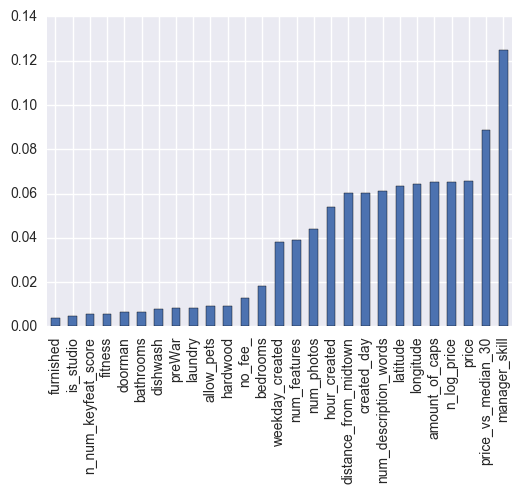

In [56]:
pd.Series(index = feats_used, data = rf.feature_importances_).sort_values().plot(kind = 'bar')

In [53]:
drace_df.columns

Index([            u'bathrooms',              u'bedrooms',
                 u'building_id',               u'created',
                 u'description',       u'display_address',
                    u'features',        u'interest_level',
                    u'latitude',            u'listing_id',
                   u'longitude',            u'manager_id',
                      u'photos',                 u'price',
          u'price_vs_median_30',        u'street_address',
                  u'num_photos',          u'num_features',
       u'num_description_words',          u'date_created',
             u'weekday_created',          u'hour_created',
                u'Price_P_Room',              u'BB_ratio',
                   u'is_studio',       u'bathroom_listed',
                 u'n_log_price',   u'n_num_keyfeat_score',
                  u'n_no_photo',        u'amount_of_caps',
                 u'n_expensive', u'distance_from_midtown',
                   u'high_frac',              u'low_frac